In [1]:
import pandas as pd
import ramanspy as rp
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.model_selection import train_test_split

In [2]:
# Load ILSdata.csv
file_path = "../data/dataset/ILSdata.csv"
ils_data = pd.read_csv(file_path)
data = pd.read_csv(file_path)

# Inspect the dataset
print("ILS Data Columns:", ils_data.columns)
print("ILS Data Shape:", ils_data.shape)

ils_target = data['conc'].values
ils_target

ILS Data Columns: Index(['labcode', 'substrate', 'laser', 'method', 'sample', 'type', 'conc',
       'batch', 'replica', '400',
       ...
       '1972', '1975', '1978', '1981', '1984', '1987', '1990', '1993', '1996',
       '1999'],
      dtype='object', length=543)
ILS Data Shape: (3516, 543)


array([0.  , 0.  , 0.  , ..., 8.87, 8.87, 8.87])

In [3]:
# Load the ILS dataset
file_path = "../data/dataset/ILSdata.csv"
data = pd.read_csv(file_path)

# Separate metadata and spectra
metadata_columns = ['labcode', 'substrate', 'laser', 'method', 'sample', 'type', 'conc', 'batch', 'replica']
spectra_data = data.drop(columns=metadata_columns)

# Separate metadata and spectra
metadata_columns = ['labcode', 'substrate', 'laser', 'method', 'sample', 'type', 'conc', 'batch', 'replica']
spectra_data = data.drop(columns=metadata_columns)  # Remove metadata columns to get spectra
spectra_data = spectra_data.apply(pd.to_numeric, errors='coerce')  # Convert to numeric, with NAs where necessary

# Print the shape of spectra_data
print("Shape of spectra_data:", spectra_data.shape)

# Convert spectra to a NumPy array
spectra_array = spectra_data.to_numpy()
# Replace NaN values with 0
spectra_array = np.nan_to_num(spectra_array, nan=0.0)

# Extract the target variable (substrate)
target = data['conc'].values
# Encode the substrate labels into integers
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)
# Convert the encoded labels to one-hot encoding
num_classes = len(label_encoder.classes_)
target_one_hot = to_categorical(target_encoded, num_classes=num_classes)

Shape of spectra_data: (3516, 534)


In [4]:
num_classes

43

In [5]:
# Check the first few rows and columns
print("First few rows and columns of spectra_data:")
print(spectra_data.iloc[:5, :10])  # First 5 rows and first 10 columns

# Check for missing values
print("Number of missing values in spectra_data:", spectra_data.isna().sum().sum())

# Check the data types
print("Data types of spectra_data columns:")
print(spectra_data.dtypes)

First few rows and columns of spectra_data:
       400      403      406      409      412      415      418      421  \
0  66533.0  66322.0  66170.0  66073.0  66129.0  66154.0  65938.0  65752.0   
1  95228.0  95066.0  94977.0  94967.0  94976.0  94761.0  94734.0  94846.0   
2  80044.0  80204.0  80182.0  79995.0  79751.0  79644.0  79693.0  79643.0   
3  77645.0  77972.0  77634.0  76632.0  75875.0  75897.0  75800.0  75655.0   
4  85099.0  84810.0  85071.0  86000.0  86656.0  85530.0  84496.0  84636.0   

       424      427  
0  65636.0  65475.0  
1  94574.0  94260.0  
2  79324.0  79090.0  
3  75470.0  75443.0  
4  84639.0  84617.0  
Number of missing values in spectra_data: 27180
Data types of spectra_data columns:
400     float64
403     float64
406     float64
409     float64
412     float64
         ...   
1987    float64
1990    float64
1993    float64
1996    float64
1999    float64
Length: 534, dtype: object


In [6]:
# Extract numeric part from column names
original_wavelengths_ils = spectra_data.columns.to_series().apply(lambda x: float(re.findall(r'\d+', x)[0]))

# Print the extracted wavelengths
print("Extracted wavelengths for ILS dataset:", original_wavelengths_ils)
print("Minimum wavelength:", original_wavelengths_ils.min())
print("Maximum wavelength:", original_wavelengths_ils.max())

# Convert spectra to a NumPy array
spectra_ils = spectra_data.to_numpy()

# Print the shape of the NumPy array
print("Shape of spectra_ils:", spectra_ils.shape)

Extracted wavelengths for ILS dataset: 400      400.0
403      403.0
406      406.0
409      409.0
412      412.0
         ...  
1987    1987.0
1990    1990.0
1993    1993.0
1996    1996.0
1999    1999.0
Length: 534, dtype: float64
Minimum wavelength: 400.0
Maximum wavelength: 1999.0
Shape of spectra_ils: (3516, 534)


In [7]:
# Load training and testing datasets
X_train, y_train = rp.datasets.bacteria("train", folder="../data/bacteria/")
X_test, y_test = rp.datasets.bacteria("test", folder="../data/bacteria/")
X_val, y_val = rp.datasets.bacteria("val", folder="../data/bacteria/")

# Convert to numpy arrays for randomization and PyTorch compatibility
X_train_bacteria = np.array(X_train.spectral_data)
y_train_bacteria = np.array(y_train)
X_test_bacteria = np.array(X_test.spectral_data)
y_test_bacteria = np.array(y_test)
X_val_bacteria = np.array(X_val.spectral_data)
y_val_bacteria = np.array(y_val)

# Combine bacteria datasets
X_bacteria = np.vstack([X_train_bacteria, X_test_bacteria, X_val_bacteria])
y_bacteria = np.hstack([y_train_bacteria, y_test_bacteria, y_val_bacteria])
# Check the shape
print("Bacteria Data Shape:", X_bacteria.shape)

Bacteria Data Shape: (66000, 1000)


print("Type of spectra_wheat:", type(spectra_wheat))
print("Available attributes and methods:", dir(spectra_wheat))

spectra_wheat_data = spectra_wheat.spectral_data

print("Shape of spectra_wheat_data:", spectra_wheat_data.shape)

In [8]:
# Load the dataset
df_wheats = rp.datasets.wheat_lines(file="../data/wheats/Data.mat", download=False)
spectra_wheat, labels, label_names = df_wheats

spectra_wheat_data = spectra_wheat.spectral_data


# Encode the labels into integers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Convert the encoded labels to one-hot encoding
num_classes = len(label_encoder.classes_)
labels_one_hot = to_categorical(labels_encoded, num_classes=num_classes)

In [9]:
print("Type of spectra_wheat:", type(spectra_wheat))
print("Available attributes and methods:", dir(spectra_wheat))

spectra_wheat_data = spectra_wheat.spectral_data

print("Shape of spectra_wheat_data:", spectra_wheat_data.shape)

Type of spectra_wheat: <class 'ramanspy.core.SpectralContainer'>
Available attributes and methods: ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'band', 'flat', 'from_stack', 'load', 'mean', 'save', 'shape', 'spectral_axis', 'spectral_data', 'spectral_length', 'tolist']
Shape of spectra_wheat_data: (53134, 1748)


In [10]:
num_classes

4

In [11]:
labels_encoded

array([0, 0, 0, ..., 3, 3, 3])

In [12]:
labels_one_hot[0]


array([1., 0., 0., 0.])

In [13]:
print("ILS Data Shape:", spectra_ils.shape)
print("Bacteria Data Shape:", X_bacteria.shape)
print("Wheat Data Shape:", spectra_wheat.shape)

ILS Data Shape: (3516, 534)
Bacteria Data Shape: (66000, 1000)
Wheat Data Shape: (53134,)


In [14]:
print("Bacteria Data Shape:", X_bacteria.shape)

Bacteria Data Shape: (66000, 1000)


import numpy as np

# Define metadata_columns (as you provided)
metadata_columns = ['labcode', 'substrate', 'laser', 'method', 'sample', 'type', 'conc', 'batch', 'replica']

# Extract spectral data from ILS dataset
spectra_ils = data.drop(columns=metadata_columns).to_numpy()

# Extract spectral data from wheat dataset
spectra_wheat = spectra_wheat.spectral_data

# Combine all spectral data
X_combined = np.vstack([spectra_ils, X_bacteria, spectra_wheat])

# Print the combined shape
print("Combined Spectral Data Shape:", X_combined.shape)

In [15]:
# Assuming the wavelength values are stored in a separate array or file
original_wavelengths_bacteria = np.linspace(250, 2000, X_bacteria.shape[1])  # Example: 250 to 2000 cm⁻¹

In [16]:
# Load wavenumbers for the bacteria dataset
original_wavelengths_bacteria = np.load("../data/bacteria/wavenumbers.npy")

# Check the shape and values
print("Bacteria Wavenumbers Shape:", original_wavelengths_bacteria.shape)
print("Bacteria Wavenumbers:", original_wavelengths_bacteria)

Bacteria Wavenumbers Shape: (1000,)
Bacteria Wavenumbers: [1792.4  1791.2  1789.9  1788.6  1787.3  1786.   1784.8  1783.5  1782.2
 1780.9  1779.6  1778.3  1777.1  1775.8  1774.5  1773.2  1771.9  1770.6
 1769.4  1768.1  1766.8  1765.5  1764.2  1762.9  1761.7  1760.4  1759.1
 1757.8  1756.5  1755.2  1753.9  1752.6  1751.3  1750.1  1748.8  1747.5
 1746.2  1744.9  1743.6  1742.3  1741.   1739.8  1738.5  1737.2  1735.9
 1734.6  1733.3  1732.   1730.7  1729.4  1728.1  1726.8  1725.5  1724.3
 1723.   1721.7  1720.4  1719.1  1717.8  1716.5  1715.2  1713.9  1712.6
 1711.3  1710.   1708.7  1707.4  1706.1  1704.8  1703.5  1702.2  1701.
 1699.7  1698.3  1697.   1695.8  1694.5  1693.2  1691.9  1690.6  1689.3
 1688.   1686.7  1685.4  1684.1  1682.8  1681.5  1680.2  1678.9  1677.5
 1676.2  1675.   1673.7  1672.3  1671.   1669.7  1668.4  1667.1  1665.8
 1664.5  1663.2  1661.9  1660.6  1659.3  1658.   1656.7  1655.4  1654.1
 1652.8  1651.5  1650.2  1648.9  1647.5  1646.2  1644.9  1643.6  1642.3
 1641. 

In [17]:
# Extract numeric part from column names
original_wavelengths_ils = spectra_data.columns.to_series().apply(lambda x: float(re.findall(r'\d+', x)[0]))

In [18]:
original_wavelengths_ils = spectra_data.columns.astype(float)

In [19]:
original_wavelengths_ils = spectra_data.columns.to_series().apply(lambda x: float(re.findall(r'\d+', x)[0]))

In [20]:
# Regenerate original_wavelengths_wheat based on the number of columns in spectra_wheat_data
num_wavelengths = spectra_wheat_data.shape[1]
original_wavelengths_wheat = np.linspace(250, 2000, num_wavelengths)  # Example range for Raman spectra

In [21]:
print("Shape of original_wavelengths_wheat:", original_wavelengths_wheat.shape)
print("Shape of spectra_wheat_data:", spectra_wheat_data.shape)

Shape of original_wavelengths_wheat: (1748,)
Shape of spectra_wheat_data: (53134, 1748)


In [23]:
# Define target size (e.g., size of the largest dataset)
target_size = 1748

# Function to resize spectra
def resize_spectra(spectra, original_wavelengths, target_size):
    resized_spectra = []
    for spectrum in spectra:
        interp_func = interp1d(original_wavelengths, spectrum, kind='linear', fill_value="extrapolate")
        new_wavelengths = np.linspace(original_wavelengths.min(), original_wavelengths.max(), target_size)
        resized_spectrum = interp_func(new_wavelengths)
        resized_spectra.append(resized_spectrum)
    return np.array(resized_spectra)

# Resize the ILS dataset
original_wavelengths_ils = spectra_data.columns.to_series().apply(lambda x: float(re.findall(r'\d+', x)[0]))
spectra_ils_resized = resize_spectra(spectra_ils, original_wavelengths_ils, target_size)
print("Resized ILS Data Shape:", spectra_ils_resized.shape)

# Resize the bacteria dataset
original_wavelengths_bacteria = np.load("../data/bacteria/wavenumbers.npy")
X_bacteria_resized = resize_spectra(X_bacteria, original_wavelengths_bacteria, target_size)
print("Resized Bacteria Data Shape:", X_bacteria_resized.shape)

# Resize the wheat dataset
spectra_wheat_resized = resize_spectra(spectra_wheat_data, original_wavelengths_wheat, target_size)
print("Resized Wheat Data Shape:", spectra_wheat_resized.shape)

# Combine resized spectral data
X_combined_resized = np.vstack([spectra_ils_resized, X_bacteria_resized, spectra_wheat_resized])

# Print the combined resized shape
print("Combined Resized Spectral Data Shape:", X_combined_resized.shape)

Resized ILS Data Shape: (3516, 1748)
Resized Bacteria Data Shape: (66000, 1748)
Resized Wheat Data Shape: (53134, 1748)
Combined Resized Spectral Data Shape: (122650, 1748)


In [24]:
# Combine labels
y_combined = np.hstack([ils_target, y_bacteria, labels_encoded])

# Print the combined labels shape
print("Combined Labels Shape:", y_combined.shape)

Combined Labels Shape: (122650,)


In [25]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform ils_target to integers
ils_target_encoded = label_encoder.fit_transform(ils_target)

print("Encoded ils_target:", ils_target_encoded)

Encoded ils_target: [ 0  0  0 ... 41 41 41]


In [26]:
ils_target, y_bacteria, labels_encoded, ils_target_encoded

(array([0.  , 0.  , 0.  , ..., 8.87, 8.87, 8.87]),
 array([ 0,  0,  0, ..., 29, 29, 29]),
 array([0, 0, 0, ..., 3, 3, 3]),
 array([ 0,  0,  0, ..., 41, 41, 41]))

In [34]:
import numpy as np


# Find the maximum value in each array
max_ils_target_encoded = np.max(ils_target_encoded)
max_y_bacteria = np.max(y_bacteria)
max_labels_encoded = np.max(labels_encoded)

# Shift y_bacteria
y_bacteria_shifted = y_bacteria + (max_ils_target_encoded + 1)

# Shift labels_encoded
labels_encoded_shifted = labels_encoded + (max_ils_target_encoded + 1) + (max_y_bacteria + 1)

# Combine the shifted arrays
combined = np.hstack([ils_target_encoded, y_bacteria_shifted, labels_encoded_shifted])

# Verify uniqueness
print("Unique values in ils_target_encoded:", np.unique(ils_target_encoded))
print("Unique values in y_bacteria_encoded:", np.unique(y_bacteria_shifted))
print("Unique values in labels_encoded_encoded:", np.unique(labels_encoded_shifted))
# Verify uniqueness
print("Unique values in combined array:", np.unique(combined))
combined.shape

Unique values in ils_target_encoded: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
Unique values in y_bacteria_encoded: [43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66
 67 68 69 70 71 72]
Unique values in labels_encoded_encoded: [73 74 75 76]
Unique values in combined array: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76]


(122650,)

 ## try model from suggested deepseek 

In [31]:
num_classes = int(np.max(combined)) + 1  # Determine the number of unique classes
y_combined_one_hot = np.eye(num_classes)[combined]
y_combined_one_hot.shape

(122650, 77)

In [40]:
X_combined_resized.shape

(122650, 1748)

In [41]:
from sklearn.model_selection import train_test_split

# Assuming X_combined_resized is your feature data and y_combined_one_hot is your label data
# First, split the data into training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X_combined_resized, y_combined_one_hot, test_size=0.2, random_state=42)

# Next, split the training+validation data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Now you have:
# X_train, y_train: Training data
# X_val, y_val: Validation data
# X_test, y_test: Test data

# You can now use these datasets to train your neural network model

In [42]:
# Check for NaN or infinite values
print("NaN values in X_train:", np.isnan(X_train).sum())
print("Infinite values in X_train:", np.isinf(X_train).sum())

# Replace NaN and infinite values
X_train = np.nan_to_num(X_train, nan=0.0, posinf=1e10, neginf=-1e10)
X_val = np.nan_to_num(X_val, nan=0.0, posinf=1e10, neginf=-1e10)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=1e10, neginf=-1e10)

# Standardize the spectral data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Build the neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model with a lower learning rate and gradient clipping
model.compile(optimizer=Adam(learning_rate=0.0001, clipvalue=1.0), loss='categorical_crossentropy', metrics=['accuracy'])

# Add callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

NaN values in X_train: 53341
Infinite values in X_train: 0


/Users/mitsuko/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.0730 - loss: 4.0445 - val_accuracy: 0.1023 - val_loss: 3.5134 - learning_rate: 1.0000e-04
Epoch 2/100
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1222 - loss: 3.3071 - val_accuracy: 0.1028 - val_loss: 3.2442 - learning_rate: 1.0000e-04
Epoch 3/100
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1219 - loss: 3.2318 - val_accuracy: 0.1275 - val_loss: 3.3087 - learning_rate: 1.0000e-04
Epoch 4/100
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1183 - loss: 3.2122 - val_accuracy: 0.1101 - val_loss: 3.3642 - learning_rate: 1.0000e-04
Epoch 5/100
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1190 - loss: 3.1816 - val_accuracy: 0.1103 - val_loss: 3.2503 - learning_rate: 1.0000e-04
Epoch 6/100
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1215 - loss: 3.1545 - val_accuracy: 0.1033 - val_loss: 3.2128 - learning_rate: 1.0000e-04
Epoch 7/100
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 3s 

In [43]:
# Standardize the spectral data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Fix the shape of the labels
y_train = y_train.reshape(-1, num_classes)  # Reshape to (num_samples, num_classes)
y_val = y_val.reshape(-1, num_classes)  # Reshape to (num_samples, num_classes)
y_test = y_test.reshape(-1, num_classes)  # Reshape to (num_samples, num_classes)

# Verify the shapes
print("Shape of y_train after fixing:", y_train.shape)
print("Shape of y_val after fixing:", y_val.shape)
print("Shape of y_test after fixing:", y_test.shape)

# Build the neural network model
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1]))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dense(128))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Add callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Shape of y_train after fixing: (78496, 77)
Shape of y_val after fixing: (19624, 77)
Shape of y_test after fixing: (24530, 77)


/Users/mitsuko/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/mitsuko/miniconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.0949 - loss: 3.8654 - val_accuracy: 0.1290 - val_loss: 3.2365 - learning_rate: 1.0000e-04
Epoch 2/100
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.1128 - loss: 3.2819 - val_accuracy: 0.1044 - val_loss: 3.2157 - learning_rate: 1.0000e-04
Epoch 3/100
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.1164 - loss: 3.2154 - val_accuracy: 0.1293 - val_loss: 3.2024 - learning_rate: 1.0000e-04
Epoch 4/100
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.1204 - loss: 3.1589 - val_accuracy: 0.1298 - val_loss: 3.1934 - learning_rate: 1.0000e-04
Epoch 5/100
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.1244 - loss: 3.1416 - val_accuracy: 0.1293 - val_loss: 3.2067 - learning_rate: 1.0000e-04
Epoch 6/100
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.1203 - loss: 3.1371 - val_accuracy: 0.1289 - val_loss: 3.2023 - learning_rate: 1.0000e-04
Epoch 7/100
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 5s 

## 2. bacterial data model

In [48]:


# Focal Loss implementation
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

# Self-attention module
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(in_dim, in_dim)
        self.key = nn.Linear(in_dim, in_dim)
        self.value = nn.Linear(in_dim, in_dim)
        
    def forward(self, x):
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        
        scores = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(x.size(-1))
        attention = torch.softmax(scores, dim=-1)
        out = torch.matmul(attention, v)
        return out

# Enhanced network architecture
class SpectraNN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(SpectraNN, self).__init__()
        
        # Input processing
        self.input_bn = nn.BatchNorm1d(1000)
        self.input_attention = SelfAttention(1000)
        
        # Deeper architecture with residual connections
        self.encoder = nn.Sequential(
            nn.Linear(1000, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate)
        )
        
        self.attention = SelfAttention(512)
        
        self.decoder = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(128, 30)
        )
        
    def forward(self, x):
        x = self.input_bn(x)
        x = x.unsqueeze(1)
        x = self.input_attention(x)
        x = x.squeeze(1)
        
        x1 = self.encoder(x)
        x2 = self.attention(x1.unsqueeze(1)).squeeze(1)
        x = x1 + x2  # Residual connection
        
        x = self.decoder(x)
        return x

# Advanced data augmentation
def augment_spectra(spectra, noise_level=0.02):
    augmented = spectra.clone()
    
    # Random noise
    noise = torch.randn_like(spectra) * noise_level
    augmented += noise
    
    # Random scaling
    scale = 1.0 + (torch.rand_like(spectra) * 0.1 - 0.05)
    augmented *= scale
    
    # Random shifts
    shift = (torch.rand_like(spectra) * 0.02 - 0.01)
    augmented += shift
    
    # Random smoothing (randomly applied)
    if torch.rand(1) > 0.5:
        kernel_size = 3
        pad_size = kernel_size // 2
        padded = torch.nn.functional.pad(augmented.unsqueeze(1), (pad_size, pad_size), mode='reflect')
        augmented = torch.nn.functional.avg_pool1d(padded, kernel_size=kernel_size, stride=1).squeeze(1)
    
    return augmented

In [ ]:

X_train, X_temp, y_train, y_temp = train_test_split(X_combined_resized, y_combined_one_hot, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize the data
# scaler = StandardScaler()
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize model and training components
print("\nInitializing model...")
model = SpectraNN()
criterion = FocalLoss(gamma=2)
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=100)

# Training loop
best_val_accuracy = 0
patience = 15
patience_counter = 0
epochs = 10

print("\nStarting training...")
for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        # Multiple augmentations per batch
        X_aug = torch.cat([augment_spectra(X_batch) for _ in range(2)])
        y_aug = torch.cat([y_batch for _ in range(2)])
        
        outputs = model(X_aug)
        loss = criterion(outputs, y_aug)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item()
        predicted = outputs.max(1)
        train_total += y_aug.size(0)
        train_correct += predicted.eq(y_aug).sum().item()
        
    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for X_val, y_val in val_loader:
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += y_val.size(0)
            val_correct += predicted.eq(y_val).sum().item()
    
    # Print metrics
    train_accuracy = train_correct / train_total
    val_accuracy = val_correct / val_total
    
    print(f'Epoch: {epoch+1}')
    print(f'Train Loss: {train_loss/len(train_loader):.4f} | Train Acc: {train_accuracy:.4f}')
    print(f'Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {val_accuracy:.4f}')
    print('-' * 50)
    
    # Save best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print('Early stopping!')
            break
    
    scheduler.step()


Initializing model...

Starting training...


RuntimeError: running_mean should contain 1748 elements not 1000

In [50]:
model = SpectraNN()
# Test evaluation with ensemble predictions
print("\nEvaluating final model...")
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

def ensemble_predict(model, X, n_augmentations=5):
    predictions = []
    with torch.no_grad():
        # Original prediction
        pred = model(X)
        predictions.append(pred)
        
        # Augmented predictions
        for _ in range(n_augmentations-1):
            aug_X = augment_spectra(X)
            pred = model(aug_X)
            predictions.append(pred)
    
    return torch.stack(predictions).mean(0)

# Final evaluation
outputs = ensemble_predict(model, X_test_tensor)
_, predicted = outputs.max(1)
accuracy = predicted.eq(y_test_tensor).float().mean()
print(f'\nFinal Test Accuracy: {accuracy:.4f}')

# Per-class accuracy
class_correct = list(0. for i in range(30))
class_total = list(0. for i in range(30))

with torch.no_grad():
    for i in range(len(y_test_tensor)):
        label = y_test_tensor[i]
        class_correct[label] += (predicted[i] == label).item()
        class_total[label] += 1

print('\nPer-class accuracy:')
for i in range(30):
    if class_total[i] > 0:
        print(f'Accuracy of class {i}: {100 * class_correct[i] / class_total[i]:.2f}%')



Evaluating final model...


/var/folders/tb/4n3fh0qx0q734bc626dps61r0000gn/T/ipykernel_501/81190938.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'

RuntimeError: running_mean should contain 1748 elements not 1000

In [ ]:
# predicted.shape, y_test_tensor.shape

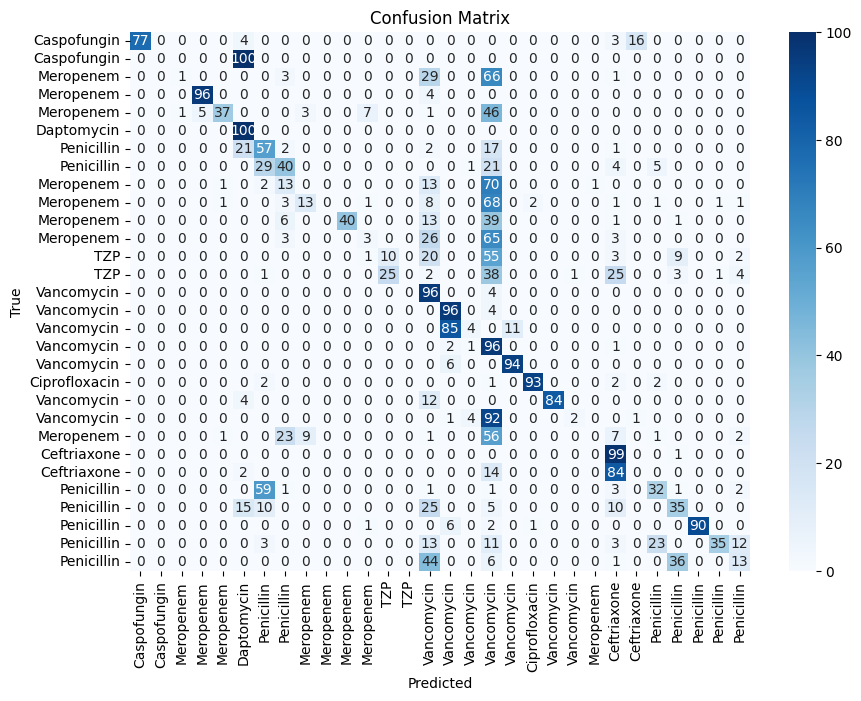

In [163]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 3: Compute the confusion matrix
cm = confusion_matrix(y_test_tensor, predicted)

# Step 4: Visualize the confusion matrix
plt.figure(figsize=(10, 7))
y_labels, antibiotics_labels = rp.datasets.bacteria("labels")
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=antibiotics_labels, yticklabels=antibiotics_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [164]:
antibiotics_labels

['Caspofungin',
 'Caspofungin',
 'Meropenem',
 'Meropenem',
 'Meropenem',
 'Daptomycin',
 'Penicillin',
 'Penicillin',
 'Meropenem',
 'Meropenem',
 'Meropenem',
 'Meropenem',
 'TZP',
 'TZP',
 'Vancomycin',
 'Vancomycin',
 'Vancomycin',
 'Vancomycin',
 'Vancomycin',
 'Ciprofloxacin',
 'Vancomycin',
 'Vancomycin',
 'Meropenem',
 'Ceftriaxone',
 'Ceftriaxone',
 'Penicillin',
 'Penicillin',
 'Penicillin',
 'Penicillin',
 'Penicillin']

## from adenine model

In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import ramanspy as rp

from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.preprocessing import StandardScaler, RobustScaler



# Split the data into training (80%), validation (10%), and test (10%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_combined_resized, y_combined_one_hot, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize the data
# scaler = StandardScaler()
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Build the neural network model
model = Sequential()

# Input layer
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))

# Hidden layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))  # Dropout for regularization
model.add(Dense(32, activation='relu'))

# Output layer (for multi-class classification)
model.add(Dense(num_classes, activation='softmax'))

# Compile the model with a lower learning rate and gradient clipping
model.compile(optimizer=Adam(learning_rate=0.001, clipvalue=1.0), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Make predictions on the test set
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class labels

# Decode the predicted labels back to substrate names
predicted_substrates = label_encoder.inverse_transform(predicted_labels)

# Compare predictions with actual values
for i in range(5):
    print(f"Predicted: {predicted_substrates[i]}, Actual: {label_encoder.inverse_transform([np.argmax(y_test[i])])[0]}")

/Users/mitsuko/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 128)            │       223,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 77)             │         2,541 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,749 (924.80 KB)

 Trainable params: 236,749 (924.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.0111 - loss: nan - val_accuracy: 0.0023 - val_loss: nan
Epoch 2/50
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.0019 - loss: nan - val_accuracy: 0.0023 - val_loss: nan
Epoch 3/50
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.0017 - loss: nan - val_accuracy: 0.0023 - val_loss: nan
Epoch 4/50
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.0019 - loss: nan - val_accuracy: 0.0023 - val_loss: nan
Epoch 5/50
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.0021 - loss: nan - val_accuracy: 0.0023 - val_loss: nan
Epoch 6/50
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.0022 - loss: nan - val_accuracy: 0.0023 - val_loss: nan
Epoch 7/50
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.0018 - loss: nan - val_accuracy: 0.0023 - val_loss: nan
Epoch 8/50
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.0017 - loss: nan - val_accuracy: 0.0023 - val_loss: nan
Epoch 9/

ValueError: y contains previously unseen labels: [64]